# Dealing with Noise

Taking derivatives is particularly challenging in the presence of noise, because the peaky, pointy nature of random variations can cause dramamtic local deviations of function slope.

## Theory

First we need to cover some concepts.

### Noise and Signal are Typically Frequency-Separable

> "Every spectrum of real noise falls off reasonably rapidly as you go to infinite frequencies, or else it would have infinite energy. But the sampling process aliases higher frequencies in lower ones, and the folding ... tends to produce a flat specturm. ... *white noise*. The signal, usually, is mainly in the lower frequencies."  
–Richard Hamming, *The Art of Doing Science and Engineering*, Digital Filters III

We expect our sampling rate to be fast enough to capture fluctuations of interest in the data, e.g. the Nyquist rate (2x the highest frequency of interest in the data), so most signal energy is expressed by relatively low frequencies. Noise shows up at all frequencies (FFT of Gaussian noise looking like more Gaussian noise), but the more we sample, the more we can distribute its energy across frequencies, hopefully putting most of its mass at *higher frequency* than the data. Thus we can separate data from noise in the frequency domain!

*All noise reduction methods are at bottom low-pass filters*: averaging, Kalman filtering, etc.

### Filtering with the Fourier Basis

A classic FIR or IIR low-pass filter from Signal Processing, like a Butterworth Filter, works from one end of the signal toward the other "causally", dampening higher-frequencies with only *local*, past and present samples, literally by taking some weighted combination of a few local input values and adding a weighted combination of a few past output values.

But if we have the whole history of a signal, then there is no need to constrain ourselves locally; we can transform the entire thing to a Fourier basis representation, where modes correspond to frequencies. Hence a common noise removal strategy is:

1. FFT the signal
2. Zero out higher Fourier modes/coefficients
3. IFFT to recover the filtered signal

This achieves an *idealized* lowpass filter, where we get perfect cutoff, as opposed to a causal filter where we instead get power rolloff of, e.g., 20dB/decade.

### Connection to Error Correcting Codes

Because a spectral representation builds a function out of basis functions that span the entire domain, every point takes the entire domain under consideration. This makes the reconstruction much more *robust* to perturbations than one that uses only a few neighboring points. I.e. it's much harder to *corrupt* the signal so thoroughly that it can't be successfully recovered.

This has an analog to [error-correcting codes](https://www.youtube.com/watch?v=X8jsijhllIA), except that in the context of continuous signals, "corruption" means (discrete representations of) continous numbers have slightly inaccurate values, whereas in error correcting codes each datum is a *single discrete bit* which can simply be *flipped*. But notice the bits corresponding to each subsequent parity check of a Hamming Code correspond to "higher-frequency" selections:

<img src="hamming.png" width=500 />

From Richard Hamming's book, *The Art of Doing Science and Engineering*, with my drawings in the margins.

In a spectral method, the coefficients say "You need to add in this much of the $k^{th}$ basis function, but in error correcting codes the analogous parity checks say "There is/isn't a parity error among my bits." In both cases a spot-corruption will stand out, because it appears in a particular combination of parity checks or introduces a value that can't be as easily/smoothly represented with a finite combination of basis functions.

### Filtering with More Exotic Bases

To avert Gibbs phenomenon or achieve better compression (more energy represented in fewer modes), we may prefer to use a basis of Chebyshev polynomials, PCA modes via SVD, wavelets, etc. to represent a signal.

All bases have "lower frequency" and "higher frequency" elements, meaning some modes have fewer transitions between low and high values, and some have more. As in Fourier basis representations, signal energy empirically tends to cluster in lower modes, and noise tends to be scattered across modes.

However, we have to be a bit more conscientious when using these modes to filter noise: If a basis function is higher-frequency over part of its domain, as Chebyshev polynomials are toward the edges of $[-1, 1]$, then that basis function is better at representing high-frequency noise in those regions, and we don't get band-separation quite as cleanly as with a uniform basis like Fourier.

## Practice

Let's put the above in to practice.

In [1]:
import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv, fourier_deriv
import numpy as np
from matplotlib import pyplot
from scipy.signal import savgol_filter, butter, sosfilt # experimented with some hybrids
from pynumdiff import savgoldiff

from IPython.display import HTML, display
def collapsible_text(text, label): # Handy function DeepSeek made for me, because my printouts were getting silly
    display(HTML(f"""<details><summary style="cursor: pointer; color: blue;">{label}</summary><pre>{text}</pre></details>"""))

### Noise with Fourier

We'll use the simple periodic singal from [the Fourier notebook](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/fourier.ipynb).

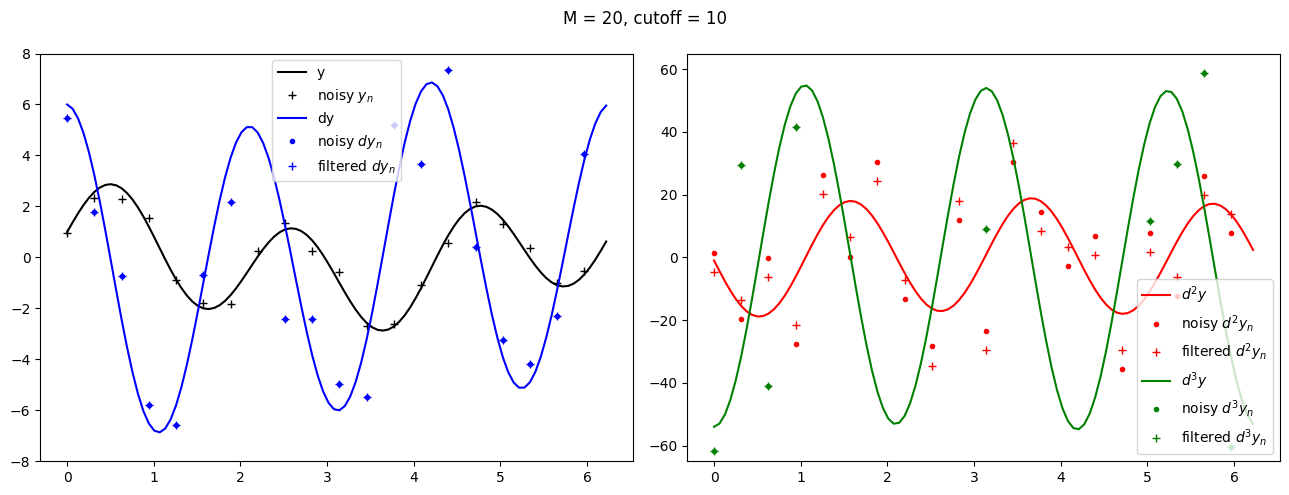

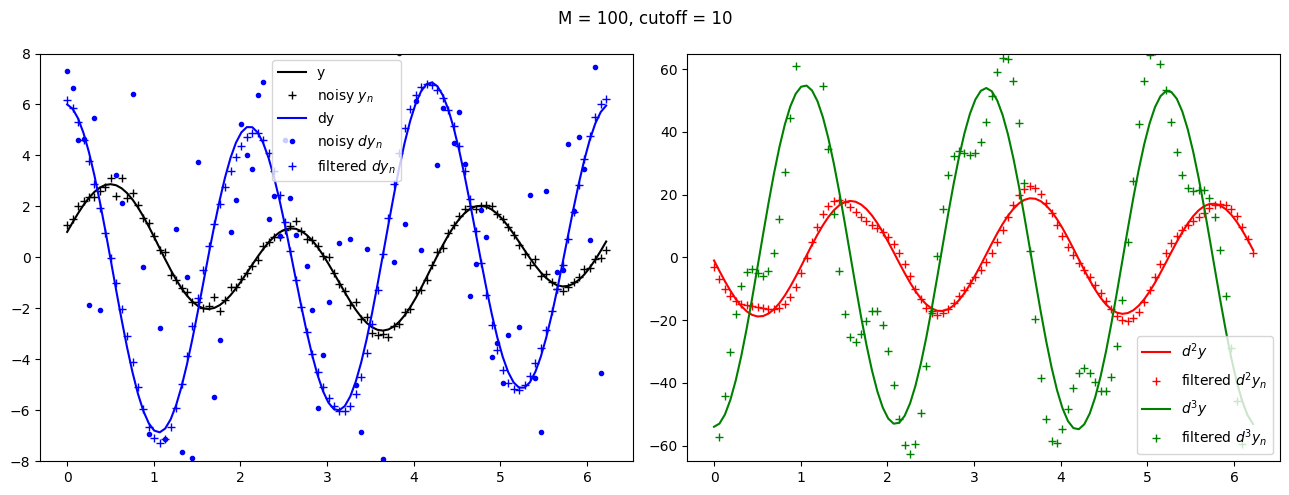

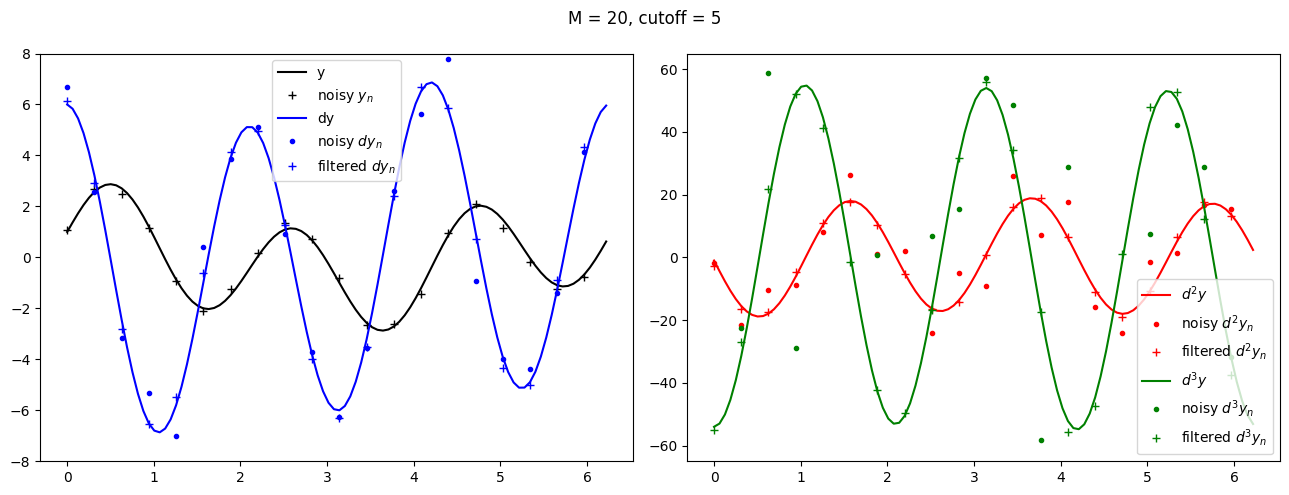

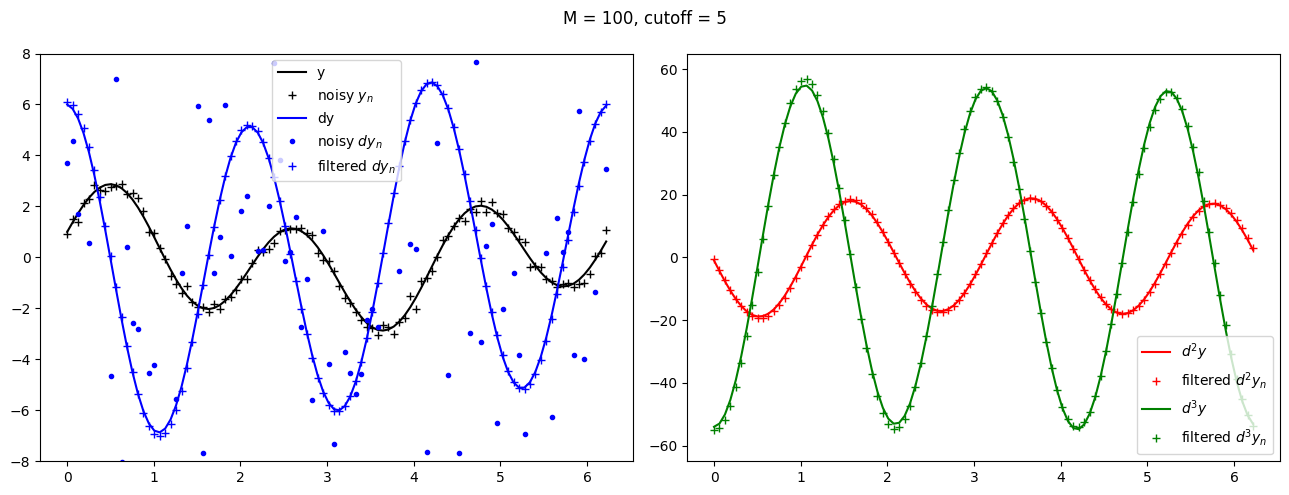

In [2]:
y = lambda th: np.cos(th) + 2*np.sin(3*th)
dy = lambda th: -np.sin(th) + 6*np.cos(3*th)
d2y = lambda th: -np.cos(th) - 18*np.sin(3*th)
d3y = lambda th: np.sin(th) - 54*np.cos(3*th)

th = np.linspace(0, 2*np.pi, 100, endpoint=False)
noise_scale = 0.2

for cutoff in (10, 5):
    for M in (20, 100):
        th_n = np.linspace(0, 2*np.pi, M, endpoint=False)
        y_n = y(th_n)
        
        y_n_with_noise = y_n + noise_scale*np.random.randn(*th_n.shape) # add in some gaussian noise
        
        dy_n = [dy(th_n), d2y(th_n), d3y(th_n)]
        dy_n_with_noise = [fourier_deriv(y_n_with_noise, th_n, nu) for nu in range(1, 4)]
        dy_n_with_filter = [fourier_deriv(y_n_with_noise, th_n, nu, filter=lambda k: np.abs(k) < cutoff) for nu in range(1, 4)]
        
        fig, axes = pyplot.subplots(1, 2, figsize=(13,5))
        fig.suptitle(f"M = {M}, cutoff = {cutoff}")
        axes[0].plot(th, y(th), 'k', label='y')
        axes[0].plot(th_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
        axes[0].plot(th, dy(th), 'b', label='dy')
        axes[0].plot(th_n, dy_n_with_noise[0], 'b.', label=r'noisy $dy_n$')
        axes[0].plot(th_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
        axes[0].set_ylim((-8, 8))
        axes[0].legend()
        axes[1].plot(th, d2y(th), 'r', label=r'$d^2y$')
        if M == 20: axes[1].plot(th_n, dy_n_with_noise[1], 'r.', label=r'noisy $d^2y_n$')
        axes[1].plot(th_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
        axes[1].plot(th, d3y(th), 'g', label=r'$d^3y$')
        if M == 20: axes[1].plot(th_n, dy_n_with_noise[2], 'g.', label=r'noisy $d^3y_n$')
        axes[1].plot(th_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
        axes[1].set_ylim((-65,65))
        axes[1].legend()
        pyplot.tight_layout()
        pyplot.show()
    
        out = ""
        for nu in range(1, 4):
            out += f"d{nu}y\n\tL∞\n"
            out += f"\t\tnoisy:\t{np.nanmax(np.abs(dy_n[nu-1] - dy_n_with_noise[nu-1]))}\n"
            out += f"\t\tfiltered:{np.nanmax(np.abs(dy_n[nu-1] - dy_n_with_filter[nu-1]))}\n"
            out += "\tL2\n"
            out += f"\t\tnoisy:\t{np.nanmean((dy_n[nu-1] - dy_n_with_noise[nu-1])**2)}\n"
            out += f"\t\tfiltered:{np.nanmean((dy_n[nu-1] - dy_n_with_filter[nu-1])**2)}\n"
        #collapsible_text(out, "numbers")

### Fourier Discussion

We can first observe filtering is *way* better than not filtering. The samples blow up so fast in the unfiltered ("noisy") case that it's not even practical to plot them past the first derivative. We can also see unfiltered noise is even more overwhelming when we include more samples, because decreased distance between them increases slopes.

It is possible for the filter to work well, but it's actually rather fragile. We see that increasing $M$ allows the lowpass filter to do *better*, which matches theory: We're band separating more of the noise from the signal. But then we also have to only *keep* some minimal number of modes, otherwise we introduce all kinds of spurious wiggles.

## Measurement Noise vs Process Noise

Noise can have a couple different sources. If noise is due to imperfect sensing, then each sample has its own little Gaussian. If there is uncertainty in the underlying dynamics, then we might say there is noise in the process itself. In Fourier land we don't really need to make a distinction between these, but due to the warp caused by cosine-sampling our data, there will be a difference in the Chebyshev basis. Let's investigate to get an intuition.

### Measurement Noise

In the case of measurement noise, our noise wave will look something like the following in the $x$ domain, with noise spread out in the middle and squished at the edges:

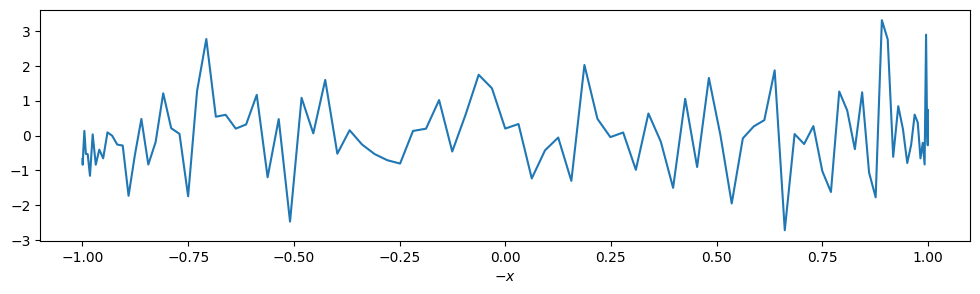

In [3]:
N = 100
noise = np.random.randn(N+1)
pyplot.figure(figsize=(12,3))
pyplot.plot(np.cos(np.arange(N+1) * np.pi / N)[::-1], noise)
pyplot.xlabel(r"$-x$");

This introduces higher frequencies in $x$, but when we transform to $\theta$, the noise gets spread out evenly:

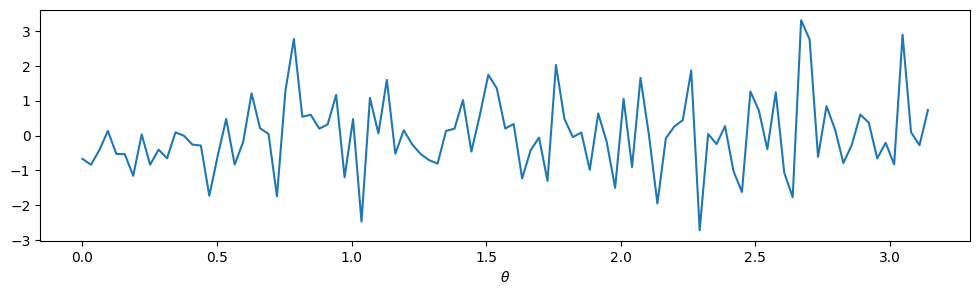

In [4]:
pyplot.figure(figsize=(12,3))
pyplot.plot(np.arange(N+1) * np.pi / N, noise)
pyplot.xlabel(r"$\theta$");

This is in fact completely analogous to noise as it appears in the Fourier case above. Huzzah!

### Process Noise

In this case we expect the noise to look more even in $x$, and *be sampled* at cosine-spaced points:

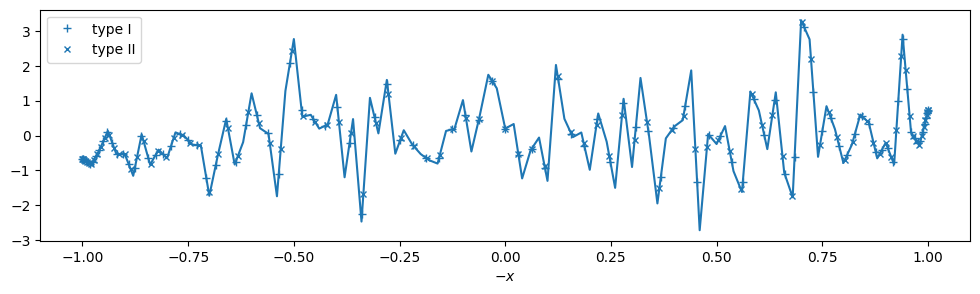

In [5]:
pyplot.figure(figsize=(12,3))
pyplot.plot(np.linspace(-1, 1, len(noise)), noise)

def cos_spaced_from_equi(y_n):
    """Interpolate the vector y_n, which is linspaced on [-1, 1], to find values at cosine-spaced points"""
    N = len(y_n) - 1
    x_lin = np.linspace(-1, 1, N+1)
    dx = x_lin[1] - x_lin[0]
    
    x_cos = np.cos(np.arange(N+1) * np.pi / N)
    i = 0
    c_n = []
    for x_n in x_cos[::-1]: # iterate low to high to fit my intuition
        while not x_lin[i] <= x_n <= x_lin[i+1]:
            i += 1
        c_n.append( ((x_n - x_lin[i]) * y_n[i+1] + (x_lin[i+1] - x_n) * y_n[i])/dx )

    x_cos2 = np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1]))
    i = 0
    c_n2 = []
    for x_n2 in x_cos2[::-1]: # iterate low to high to fit my intuition
        while not x_lin[i] <= x_n2 <= x_lin[i+1]:
            i += 1
        c_n2.append( ((x_n2 - x_lin[i]) * y_n[i+1] + (x_lin[i+1] - x_n2) * y_n[i])/dx )
        
    return np.array(c_n[::-1]), x_cos, np.array(c_n2[::-1]), x_cos2

cos_noise, x_cos, cos_noise2, x_cos2 = cos_spaced_from_equi(noise)
pyplot.plot(x_cos, cos_noise, 'C0+', label='type I');
pyplot.plot(x_cos2, cos_noise2, 'C0x', ms=5, label='type II')
pyplot.xlabel(r"$-x$")
pyplot.legend();

With this scheme, noise samples at the tightly-packed endpoints are no longer as statistically independent as noise samples in the spaced-out middle.

Then if when we transform to the $\theta$ domain, we get a squish in the middle and spreading out at the edges:

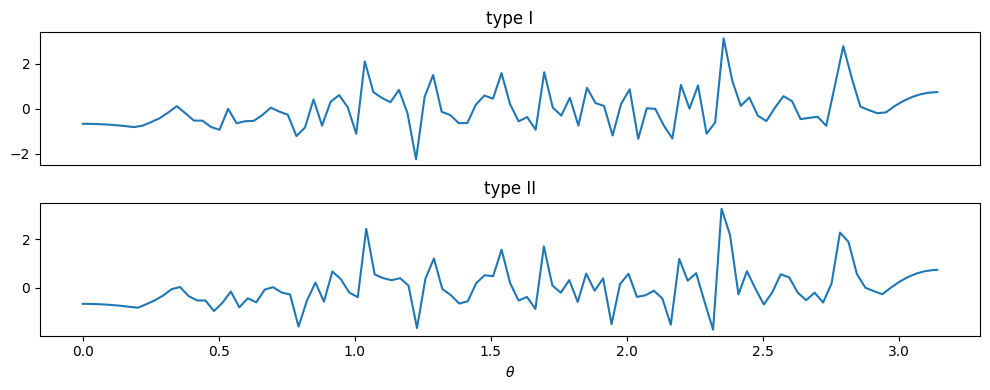

In [6]:
N = len(cos_noise) - 1
fig, axes = pyplot.subplots(2, 1, figsize=(10,4))
axes[0].set_xticks([])
axes[0].plot((np.arange(N+1) * np.pi / N)[::-1], cos_noise)
axes[0].set_title("type I")
axes[1].plot(np.concatenate(([0], (np.arange(N+1) + 0.5) * np.pi/(N+1), [np.pi]))[::-1], cos_noise2);
axes[1].set_xlabel(r'$\theta$')
axes[1].set_title("type II")
pyplot.tight_layout()

This makes the noise at the edges lower frequency, which means it's *harder* to filter and *easier* to *fit*, not what we're after. It's essentially more difficult to distinguish from legitimate signal.

### Noise with Chebyshev

Let's now try to separate both these kinds of noise from a signal with a Chebyshev transform.

I use both DCT Type I and II to see whether they fare any differently. The signal under consideration should be familiar from [the Chebyshev notebook](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev.ipynb).

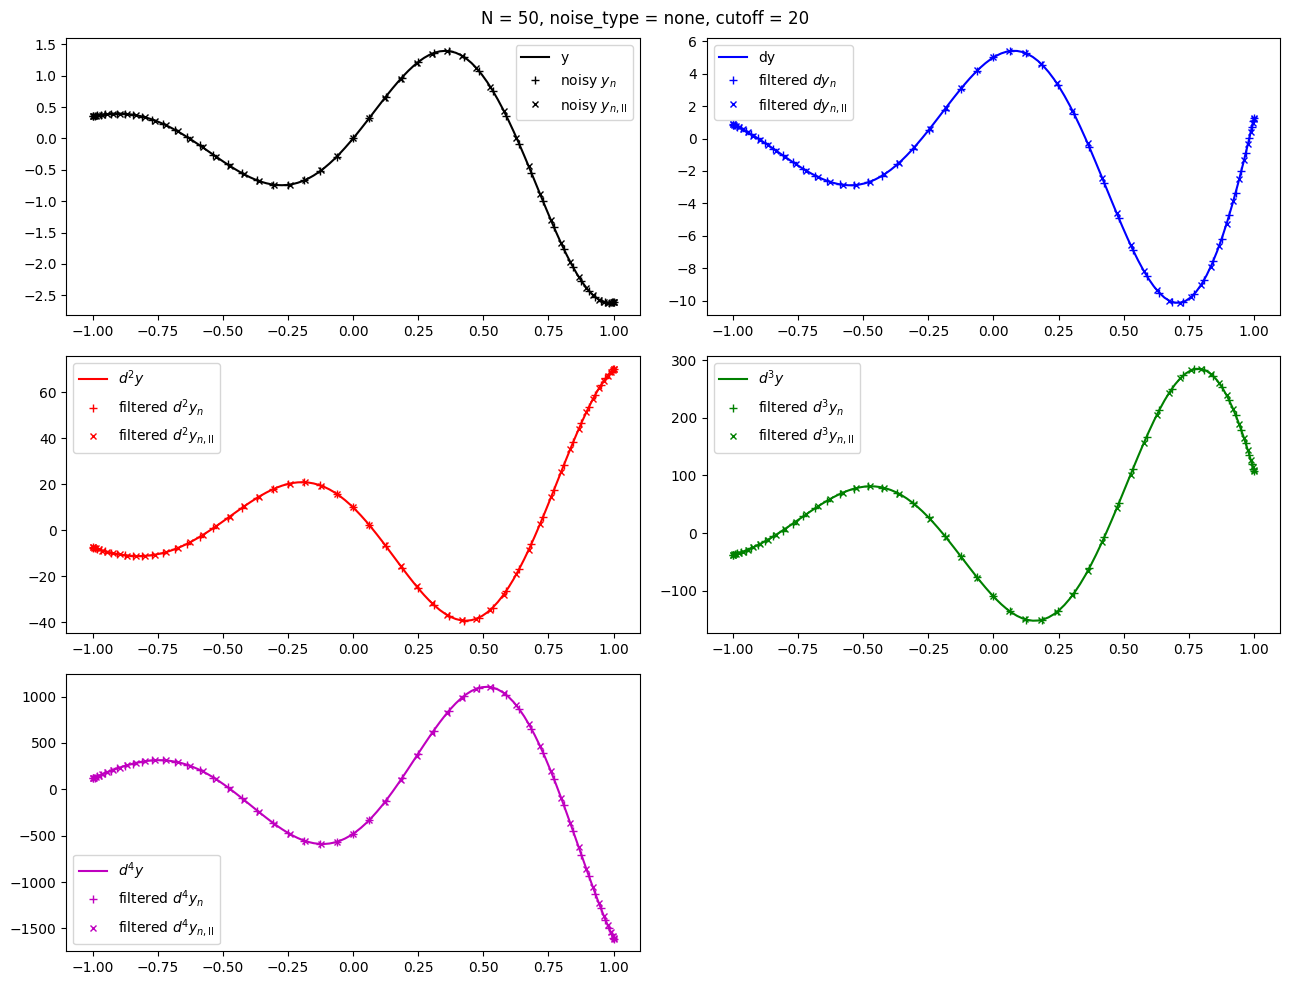

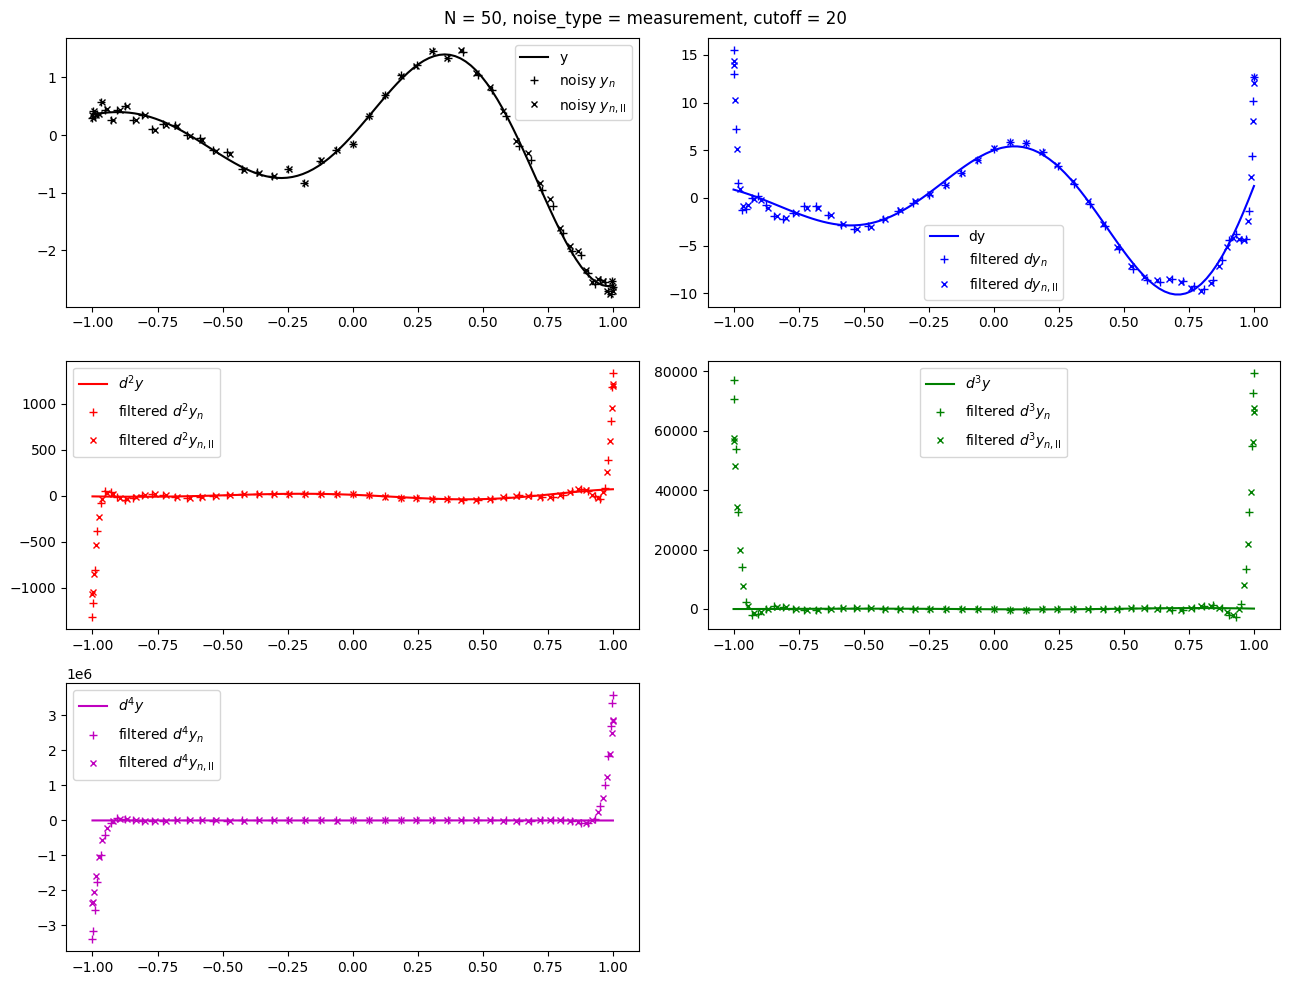

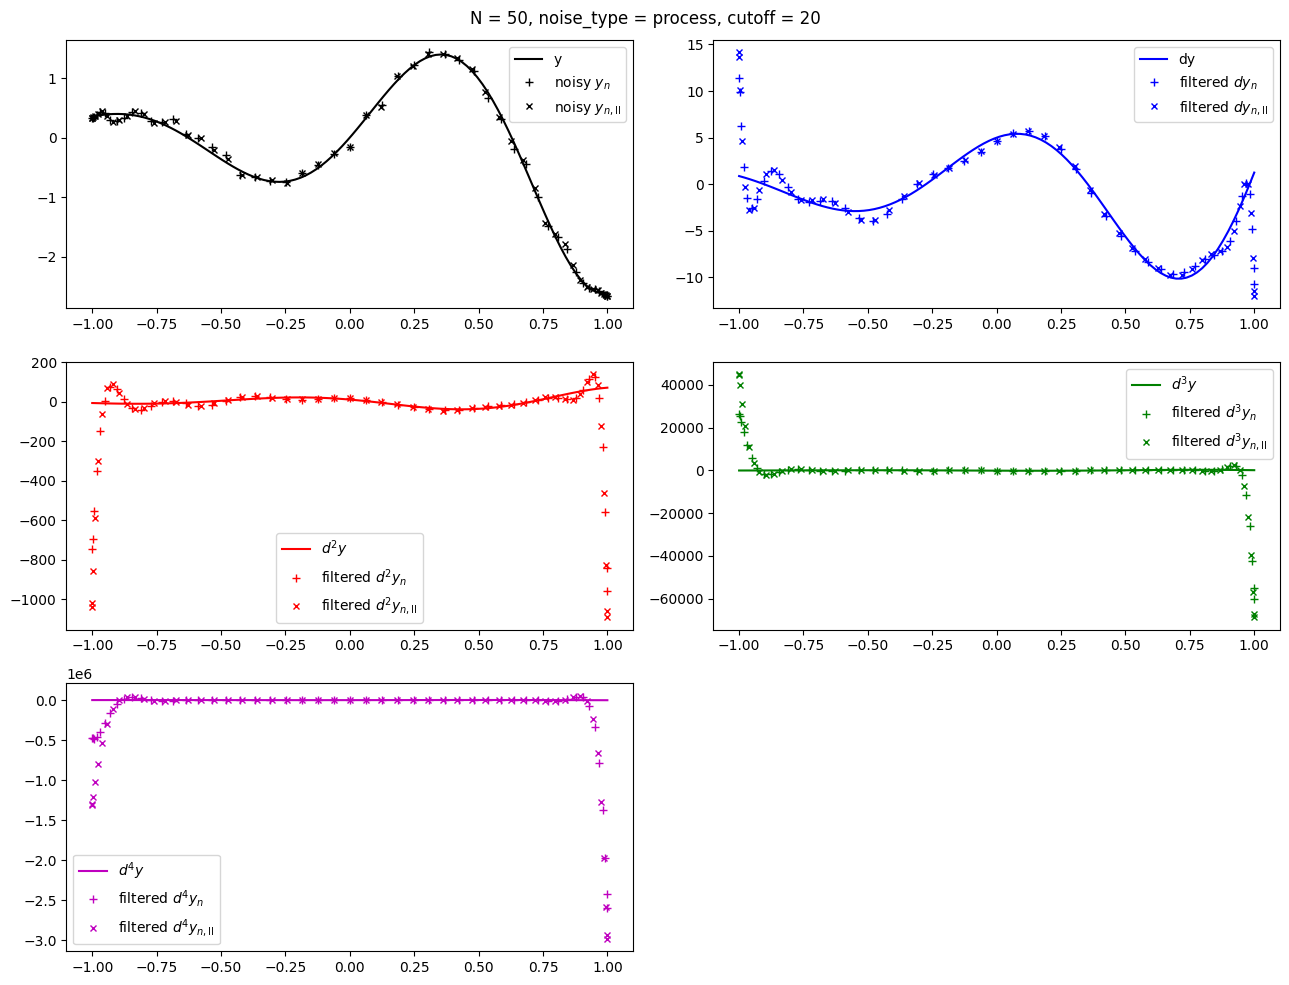

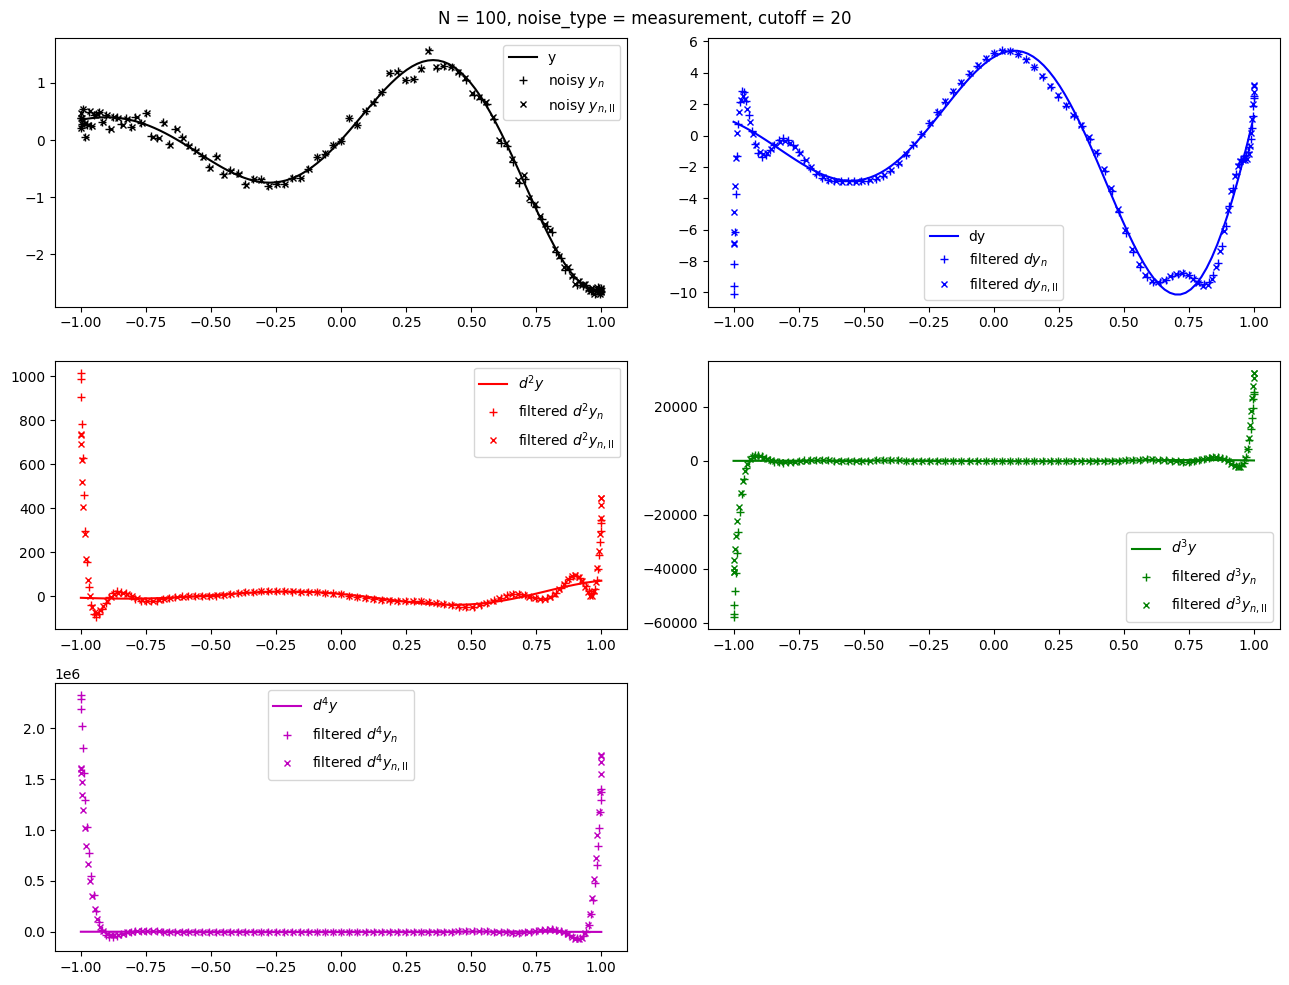

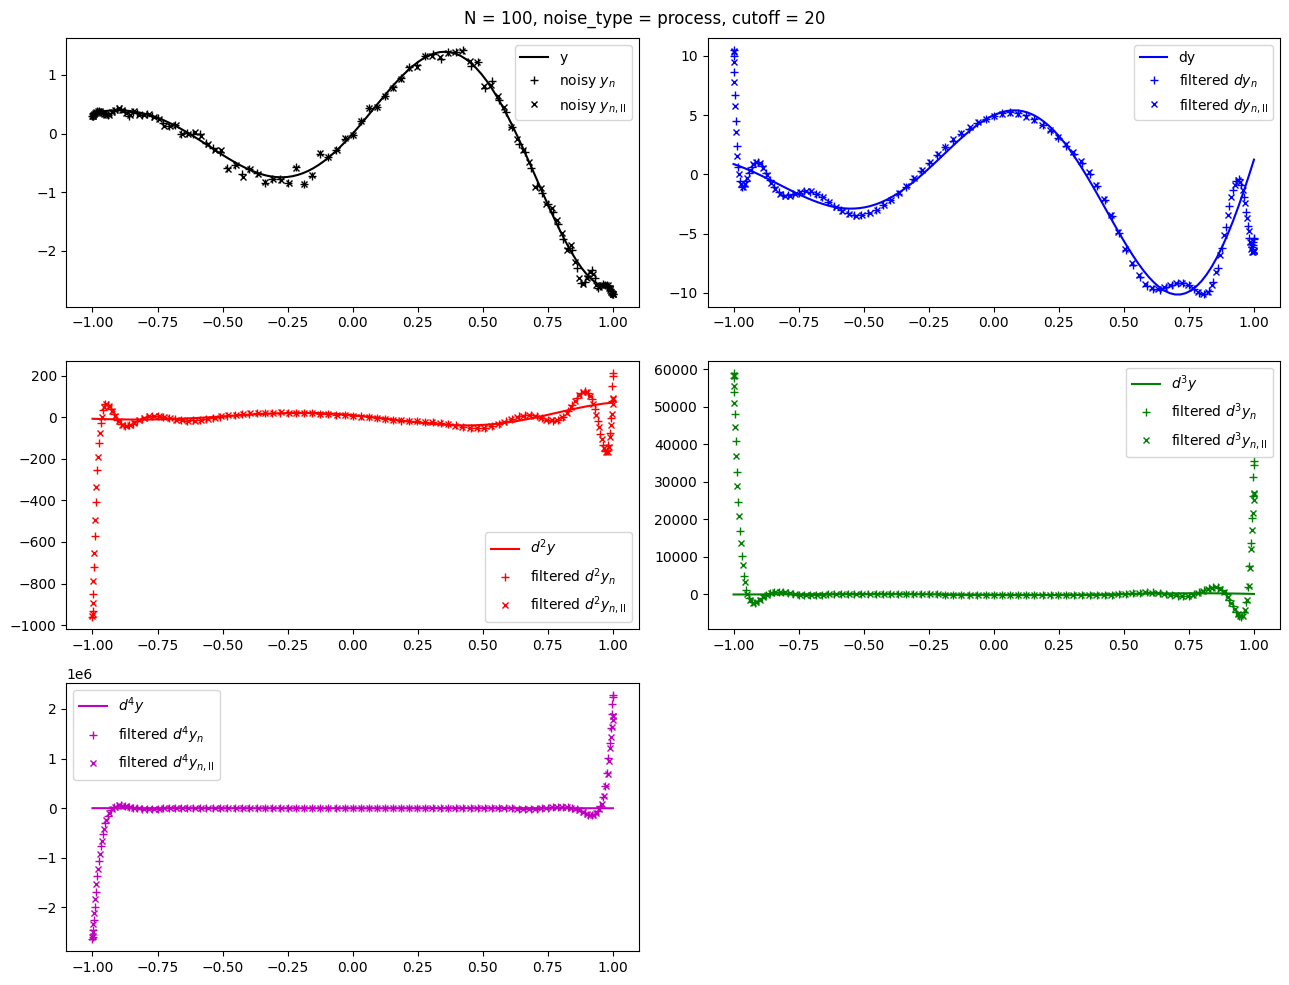

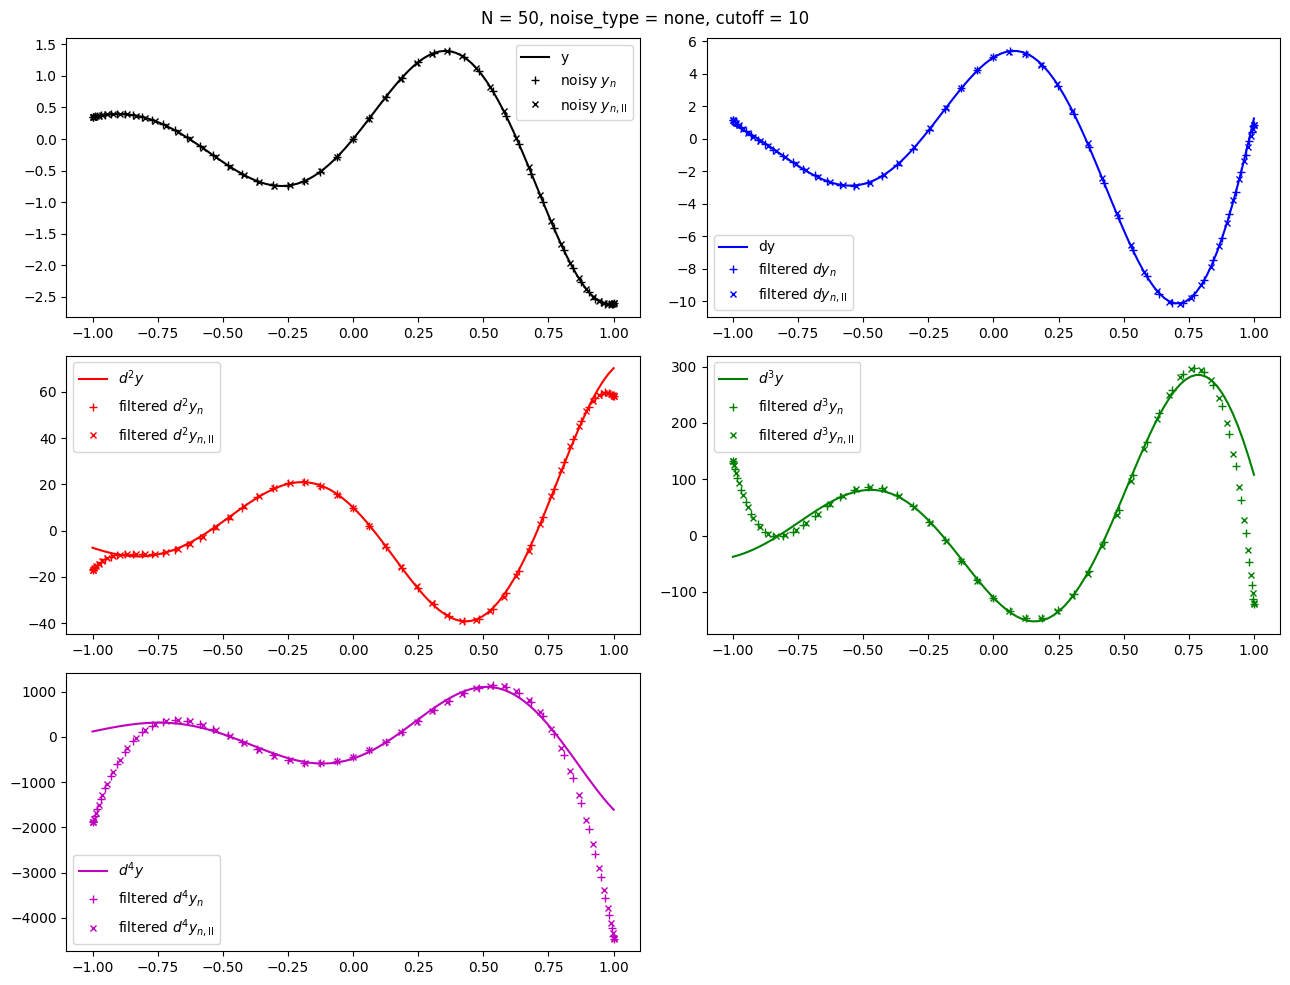

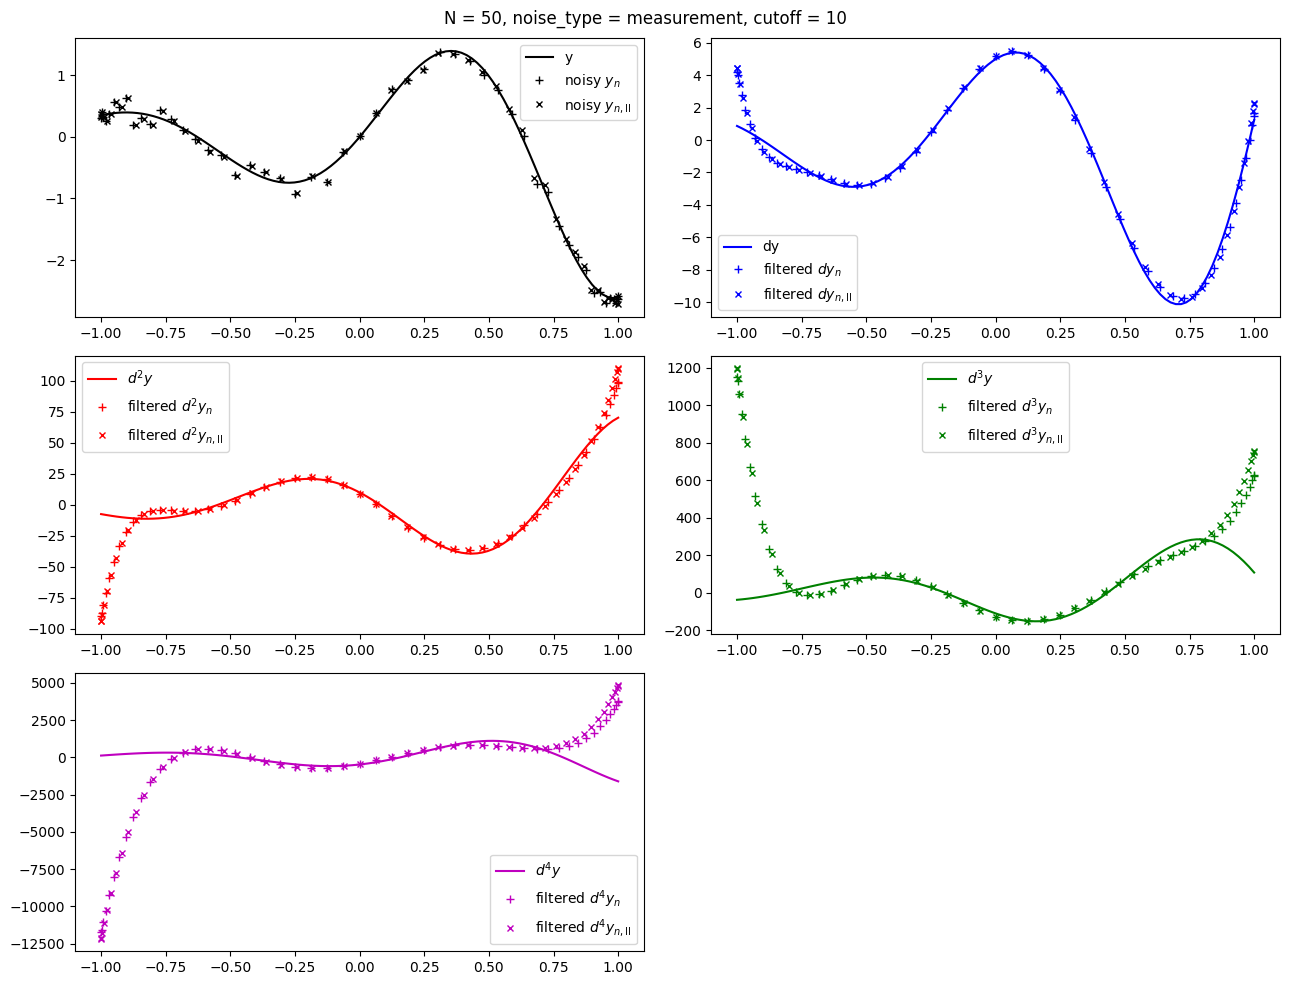

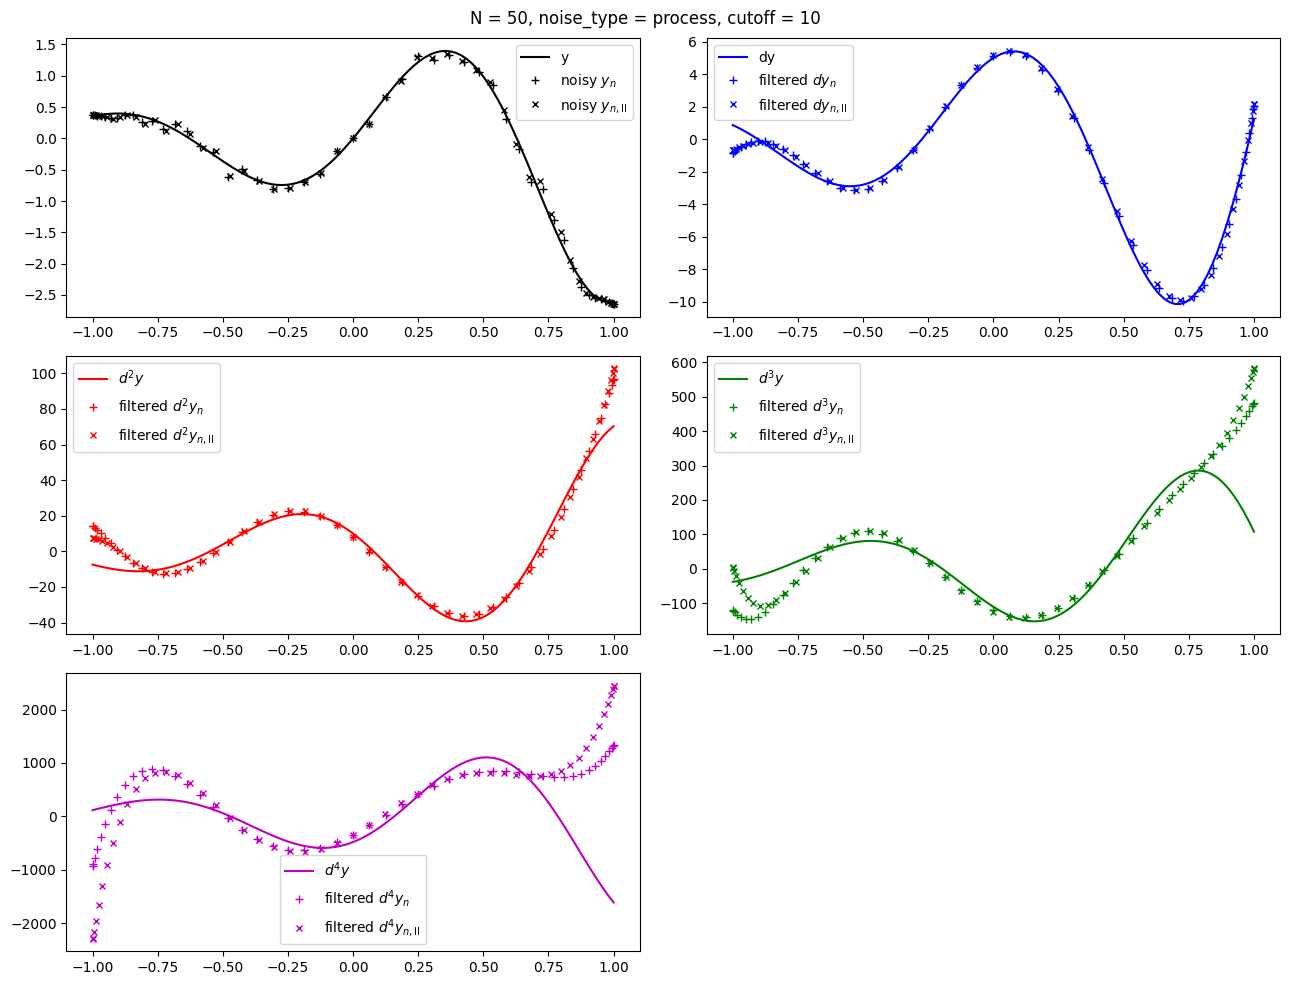

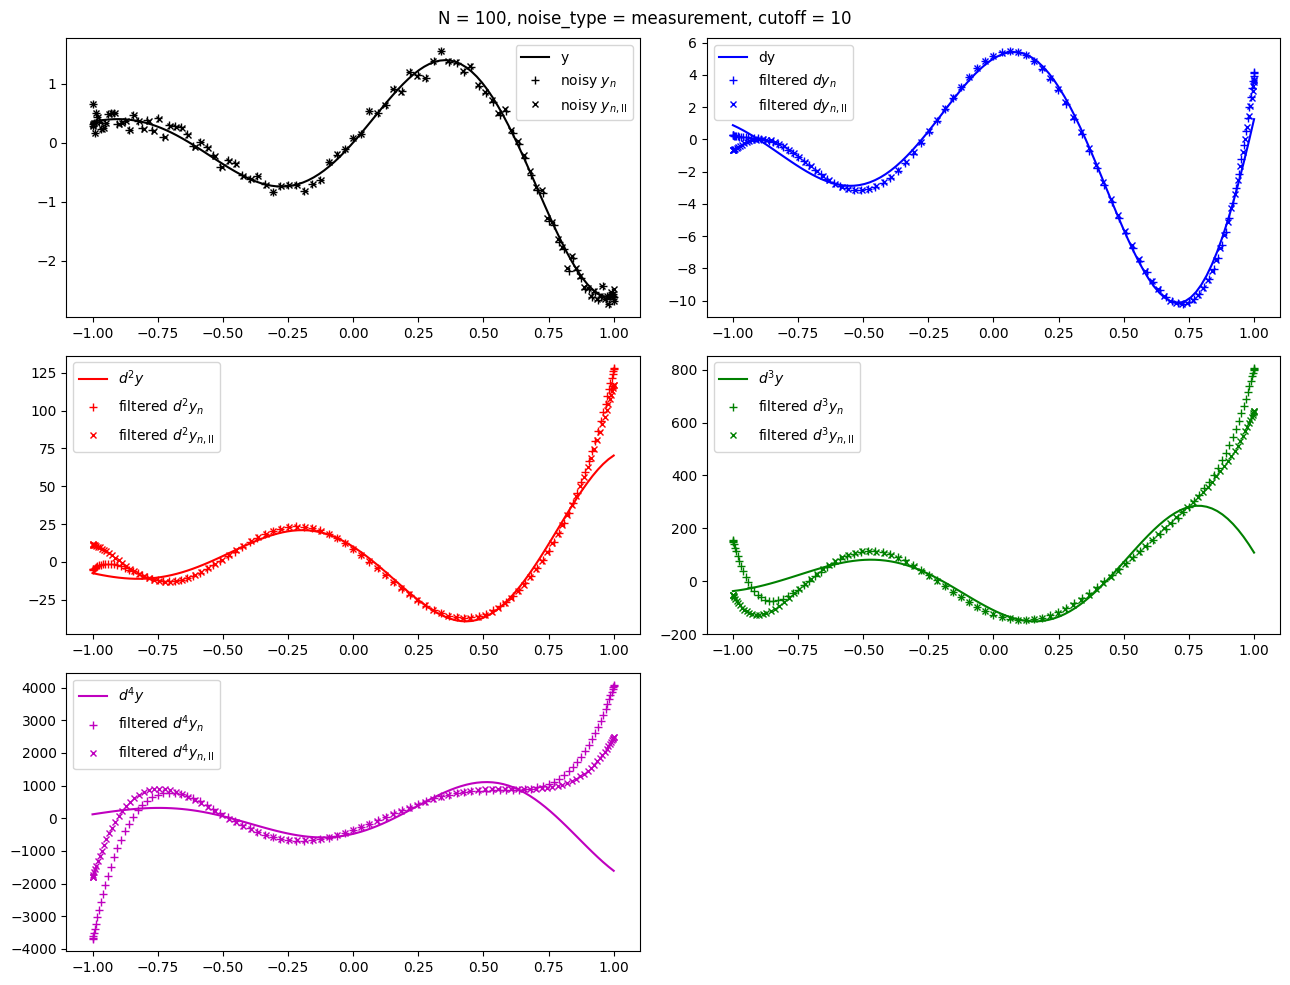

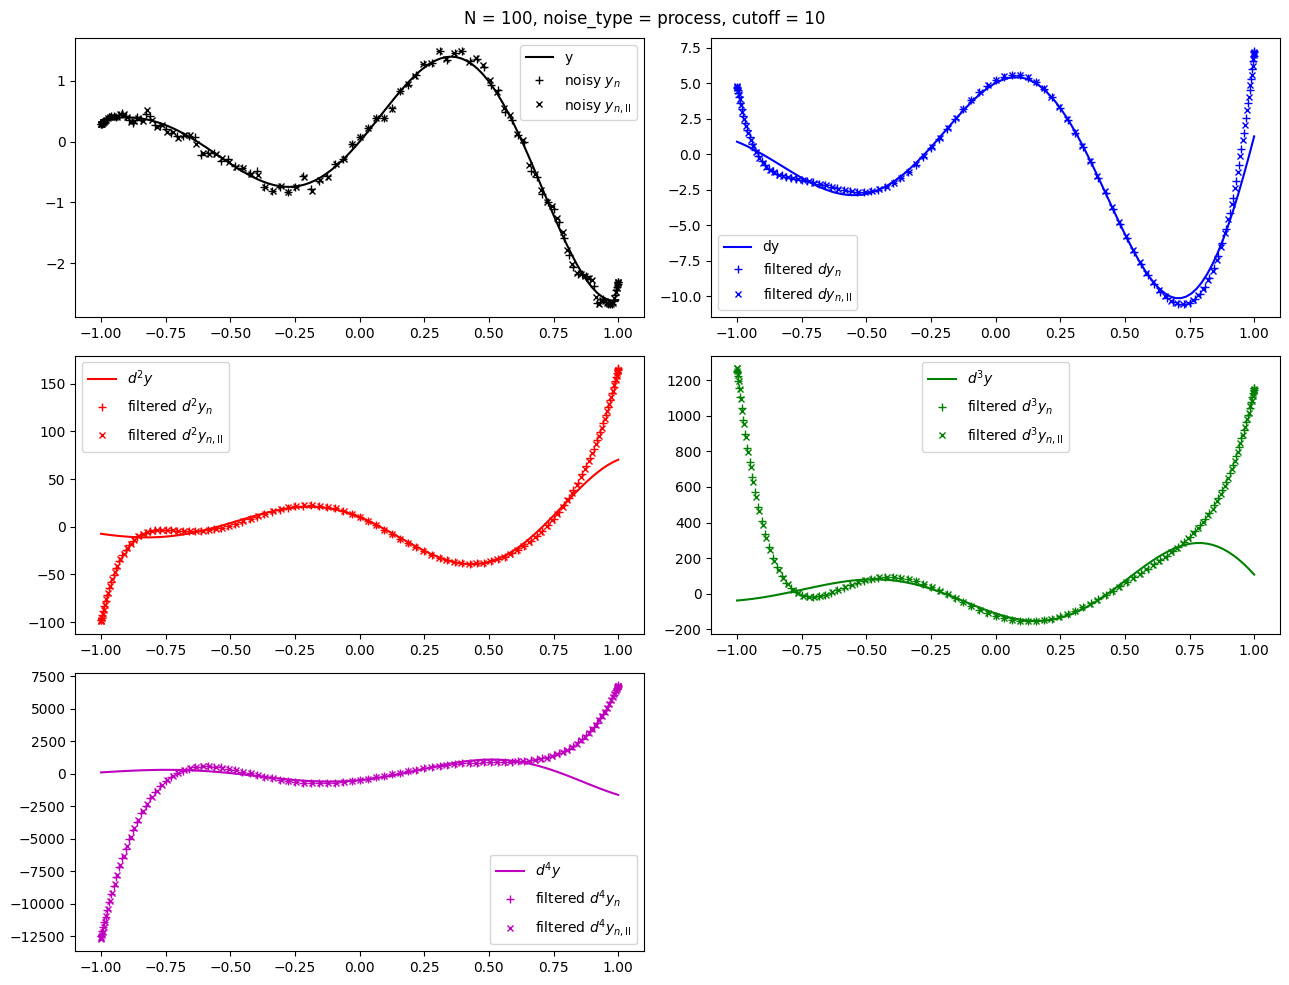

In [7]:
y = lambda x: np.exp(x) * np.sin(5*x)
dy = lambda x: 5*np.exp(x) * np.cos(5*x) + np.exp(x) * np.sin(5*x)
d2y = lambda x: 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
d3y = lambda x: -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
d4y = lambda x: 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))

x = np.linspace(-1, 1, 100)
noise_scale = 0.1

for cutoff in (20, 10):
    for N in (50, 100):
        x_n = np.cos(np.arange(N+1) * np.pi / N) # length N+1, in keeping with the usage of N in Trefethen.
        x_n2 = np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1]))
        y_n = y(x_n)
        y_n2 = y(x_n2)
    
        dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]
        dy_n2 = [dy(x_n2), d2y(x_n2), d3y(x_n2), d4y(x_n2)]
    
        equispaced_noise = np.random.randn(*x_n2.shape)
        cos_noise, _, cos_noise2, _ = cos_spaced_from_equi(equispaced_noise[1:-1])
    
        for noise_type in ["none", "measurement", "process"]:
            if noise_type == "none" and N == 100: continue # honestly there are too many plots, so let's skip a couple
            noise1 = equispaced_noise[1:-1] if noise_type == "measurement" else cos_noise if noise_type == "process" else 0
            noise2 = equispaced_noise if noise_type == "measurement" else cos_noise2 if noise_type == "process" else 0
            
            y_n_with_noise = y_n + noise_scale*noise1 # savgol_filter(y_n_with_noise, window, order) or savgoldiff(y_n_with_noise, 1, (3, 11, 11))[0]
            y_n2_with_noise = y_n2 + noise_scale*noise2 # or sosfilt(butter(order, cutoff in [0, 1], output='sos'), y_n_with_noise)
            
            dy_n_with_noise = [cheb_deriv(y_n_with_noise, x_n, nu) for nu in range(1, 5)]
            dy_n2_with_noise = [cheb_deriv(y_n2_with_noise, x_n2, nu, dct_type=2) for nu in range(1, 5)]

            dy_n_with_filter = [cheb_deriv(y_n_with_noise, x_n, nu, filter=lambda k: np.abs(k) < cutoff) for nu in range(1, 5)]
            dy_n2_with_filter = [cheb_deriv(y_n2_with_noise, x_n2, nu, filter=lambda k: np.abs(k) < cutoff, dct_type=2) for nu in range(1, 5)]
        
            fig, axes = pyplot.subplots(3, 2, figsize=(13,10))
            fig.delaxes(axes[2, 1])
            fig.suptitle(f"N = {N}, noise_type = {noise_type}, cutoff = {cutoff}")
            axes[0, 0].plot(x, y(x), 'k', label='y')
            axes[0, 0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
            axes[0, 0].plot(x_n2, y_n2_with_noise, 'kx', ms=5, label=r'noisy $y_{n,\text{II}}$')
            axes[0, 1].plot(x, dy(x), 'b', label='dy')
            #if N == 50: axes[0, 1].plot(x_n, dy_n_with_noise[0], 'b.', label=r'noisy $dy_n$')
            axes[0, 1].plot(x_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
            axes[0, 1].plot(x_n2, dy_n2_with_filter[0], 'bx', ms=5, label=r'filtered $dy_{n,\text{II}}$')
            axes[1, 0].plot(x, d2y(x), 'r', label=r'$d^2y$')
            #axes[1, 0].plot(x_n, dy_n_with_noise[1], 'r.', label=r'noisy $d^2y_n$')
            axes[1, 0].plot(x_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
            axes[1, 0].plot(x_n2, dy_n2_with_filter[1], 'rx', ms=5, label=r'filtered $d^2y_{n,\text{II}}$')
            axes[1, 1].plot(x, d3y(x), 'g', label=r'$d^3y$')
            #axes[1, 1].plot(x_n, dy_n_with_noise[2], 'g.', label=r'noisy $d^3y_n$')
            axes[1, 1].plot(x_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
            axes[1, 1].plot(x_n2, dy_n2_with_filter[2], 'gx', ms=5, label=r'filtered $d^3y_{n,\text{II}}$')
            axes[2, 0].plot(x, d4y(x), 'm', label=r'$d^4y$')
            #axes[2, 0].plot(x_n, dy_n_with_noise[3], 'm.', label=r'noisy $d^4y_n$')
            axes[2, 0].plot(x_n, dy_n_with_filter[3], 'm+', label=r'filtered $d^4y_n$')
            axes[2, 0].plot(x_n2, dy_n2_with_filter[3], 'mx', ms=5, label=r'filtered $d^4y_{n,\text{II}}$')
            for i in range(5): axes[i // 2, i % 2].legend()
            pyplot.tight_layout()
            pyplot.show()
    
            out = ""
            for nu in range(1, 5):
                out += f"d{nu}y\n\ttype I\n\t\tL∞\n"
                out += f"\t\t\traw:\t\t{np.nanmax(np.abs(dy_n[nu-1] - dy_n_with_noise[nu-1]))}\n"
                out += f"\t\t\tfiltered:\t{np.nanmax(np.abs(dy_n[nu-1] - dy_n_with_filter[nu-1]))}\n"
                out += "\t\tL2\n"
                out += f"\t\t\traw:\t\t{np.nanmean((dy_n[nu-1] - dy_n_with_noise[nu-1])**2)}\n"
                out += f"\t\t\tfiltered:\t{np.nanmean((dy_n[nu-1] - dy_n_with_filter[nu-1])**2)}\n"
                out += "\ttype II\n\t\tL∞\n"
                out += f"\t\t\tnoisy:\t\t{np.nanmax(np.abs(dy_n2[nu-1] - dy_n2_with_noise[nu-1]))}\n"
                out += f"\t\t\tfiltered:\t{np.nanmax(np.abs(dy_n2[nu-1] - dy_n2_with_filter[nu-1]))}\n"
                out += "\t\tL2\n"
                out += f"\t\t\traw:\t\t{np.nanmean((dy_n2[nu-1] - dy_n2_with_noise[nu-1])**2)}\n"
                out += f"\t\t\tfiltered:\t{np.nanmean((dy_n2[nu-1] - dy_n2_with_filter[nu-1])**2)}\n"
            #collapsible_text(out, "numbers")

### Chebyshev Discussion

In the Chebyshev basis, we appear to need *more* modes to fit the function itself, because it's asymmetrical and more complicated, and this becomes a tradeoff with noise filtration.

If we use 20 modes, we can represent this function no problem, but if we use 10, then *even in the noiseless case* we really can't, at least not at the edges. The interpolation ends up just *slightly* less steep than we need, because we're leaving off higher modes that could help us complete its representation, and this throws of subsequent derivatives ever more until we're cooked.

But if we use 20 modes in the presence of noise, the noise slips through, especially affecting the interpolation at the edges of the domain, causing extra wobbles that kill us.

It is gratifying to see that the DCT type II often (but not always) does slightly better than the DCT type I at representing the function, especially with fewer modes, matching the [types comparison intuition](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dct_types_comparison.ipynb), and my analysis from the [type extension experiments](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dct_types_extension_experiments.ipynb) and [Issue #13](https://github.com/pavelkomarov/spectral-derivatives/issues/13). However, it's not enough to save us.

I've tried to brainstorm ways around this in [Issue #14](https://github.com/pavelkomarov/spectral-derivatives/issues/14) without success. In the end it seems the Chebyshev basis fundamentally can't accomplish noise separation as well as the Fourier basis, and we unfortunately can't use the Fourier basis for noise filtration in the aperiodic case, because then Gibbs phenomenon introduces a whole other source of copious new noise!

To further complicate matters, a fast Chebyshev method depends on cosine-spaced sampling, but most filtration methods assume equispaced samples and are [computationally more expensive to generalize to non-uniform samplings](https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data).

Filtering is just tricky and can be fragile. Proceed with care.

## Comparison with Savitzky-Golay + Gaussian Smoothing

It's worth comparing the above to a local method.

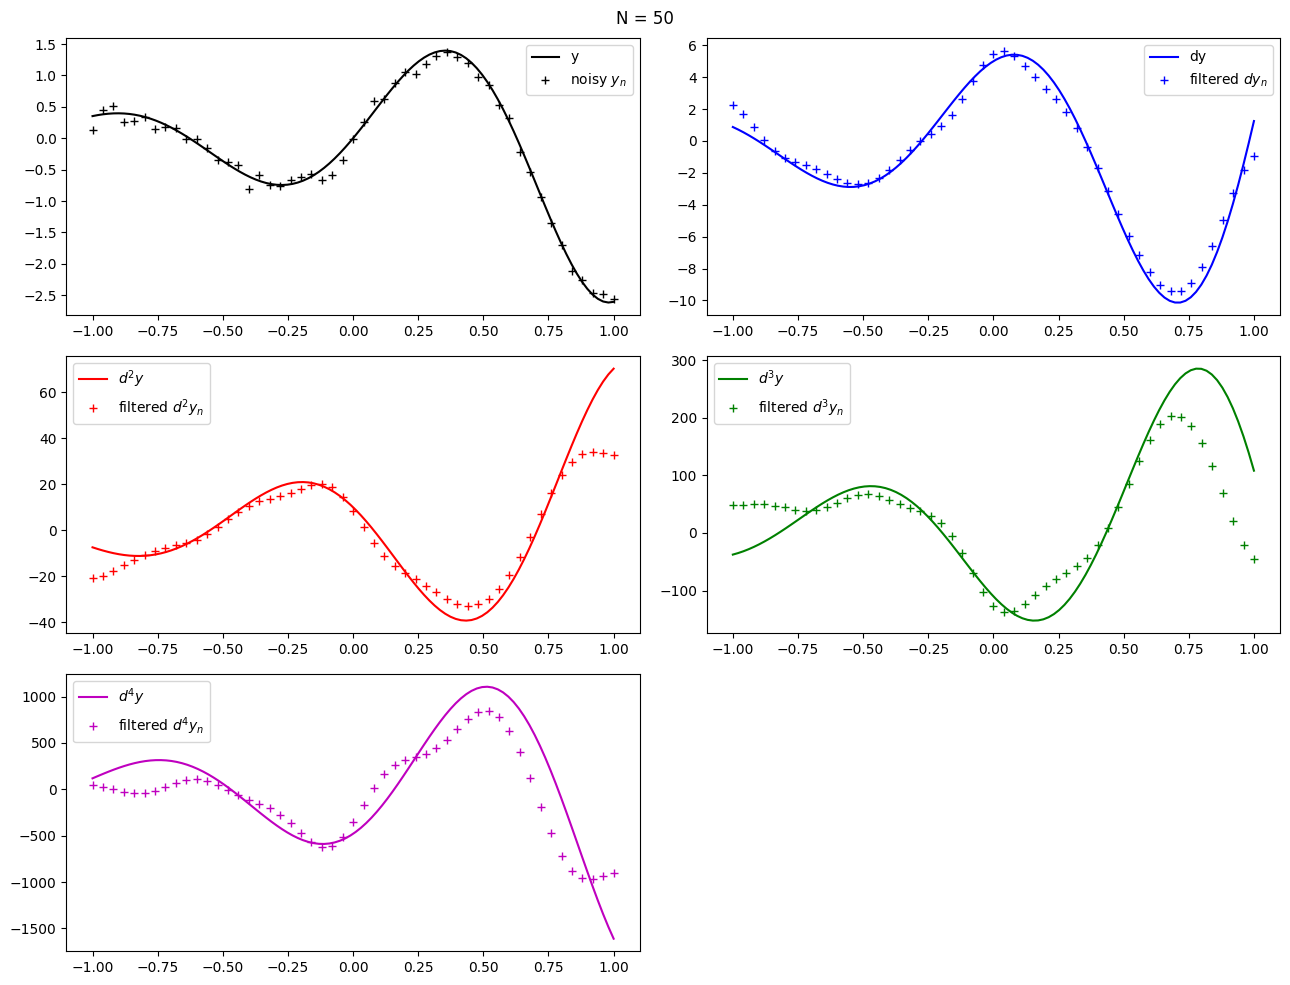

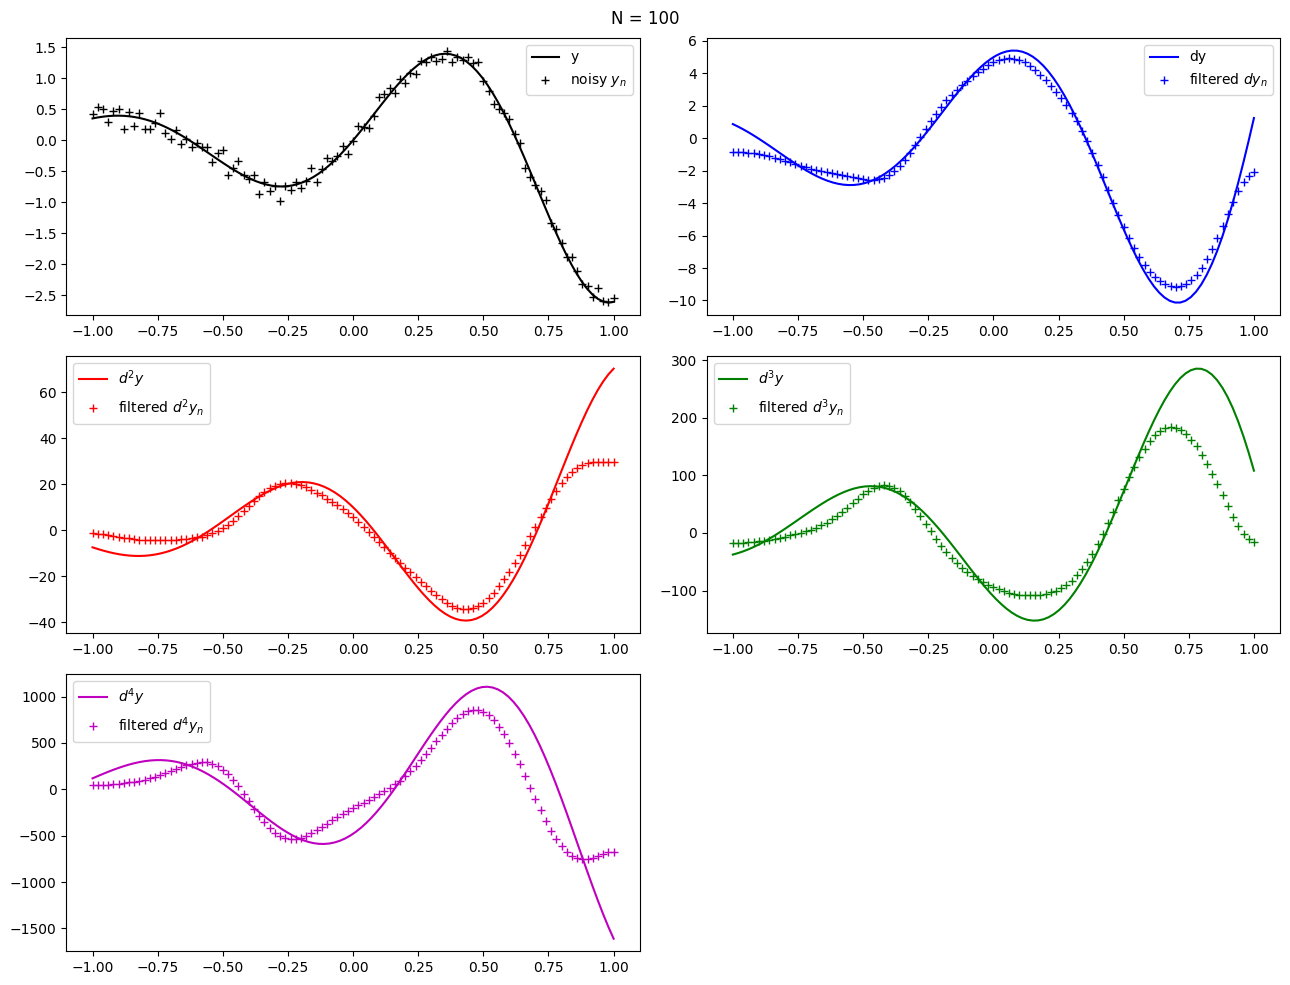

In [8]:
for N in (50, 100):
    x_n = np.linspace(-1, 1, N+1)
    dx = x_n[1] - x_n[0]
    
    y_n = y(x_n)
    dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]

    y_n_with_noise = y_n + noise_scale*np.random.randn(*x_n.shape)
    #dy_n_with_filter = [savgol_filter(y_n_with_noise, 11, 4, deriv=nu)/dx**nu for nu in range(1,5)]
    dy_n_with_filter = [savgoldiff(y_n_with_noise, dx, (3, N//5+1, N//5+1))[1]] # Floris' function only does one derivative at a time
    for nu in range(2, 5):
        dy_n_with_filter.append(savgoldiff(dy_n_with_filter[-1], dx, (3,  N//5+1, N//5+1))[1])
    
    fig, axes = pyplot.subplots(3, 2, figsize=(13,10))
    fig.delaxes(axes[2, 1])
    fig.suptitle(f"N = {N}")
    axes[0, 0].plot(x, y(x), 'k', label='y')
    axes[0, 0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
    axes[0, 1].plot(x, dy(x), 'b', label='dy')
    axes[0, 1].plot(x_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
    axes[1, 0].plot(x, d2y(x), 'r', label=r'$d^2y$')
    axes[1, 0].plot(x_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
    axes[1, 1].plot(x, d3y(x), 'g', label=r'$d^3y$')
    axes[1, 1].plot(x_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
    axes[2, 0].plot(x, d4y(x), 'm', label=r'$d^4y$')
    axes[2, 0].plot(x_n, dy_n_with_filter[3], 'm+', label=r'filtered $d^4y_n$')
    for i in range(5): axes[i // 2, i % 2].legend()
    pyplot.tight_layout()
    pyplot.show()
    
    out = ""
    for nu in range(1, 5):
        out += f"d{nu}y\n\ttype I\n\t\tL∞\n"
        out += f"\t\t\tfiltered:\t{np.nanmax(np.abs(dy_n[nu-1] - dy_n_with_filter[nu-1]))}\n"
        out += "\t\tL2\n"
        out += f"\t\t\tfiltered:\t{np.nanmean((dy_n[nu-1] - dy_n_with_filter[nu-1])**2)}\n"
        out += "\ttype II\n\t\tL∞\n"
        out += f"\t\t\tfiltered:\t{np.nanmax(np.abs(dy_n2[nu-1] - dy_n2_with_filter[nu-1]))}\n"
        out += "\t\tL2\n"
        out += f"\t\t\tfiltered:\t{np.nanmean((dy_n2[nu-1] - dy_n2_with_filter[nu-1])**2)}\n"
    #collapsible_text(out, "numbers")

### Discussion

It's also quite hard to make this work, and in many cases/with many parameter choices the 1st derivative fit does significantly worse than the spectral method. But this method suffers less from systematic blowup at the domain edges as we go to higher derivatives.